In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Megafon/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Megafon/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Megafon/sample_submission.csv')

In [6]:
train_df.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,control,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,control,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,treatment,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,treatment,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,treatment,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [7]:
train_df['conversion'].value_counts()

0    477486
1    122514
Name: conversion, dtype: int64

In [8]:
train_df['treatment_group'].value_counts()

treatment    300368
control      299632
Name: treatment_group, dtype: int64

In [ ]:
train_df.info()

In [9]:
test_df.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,control,-21.671252,-0.621024,-2.842075,-51.831110,129.636266,-285.756326,-61.093746,138.041078,29.513636,94.443475,-54.196343,5.343785,22.890318,47.667849,165.555221,-52.613203,-130.236850,-2.010024,7.350980,9.296528,220.057254,384.666236,0.462698,1.819293,165.530813,-75.013396,-13.882029,30.737391,106.678702,0.881631,-67.059250,-24.487088,-135.689760,-17.204304,-38.725890,26.071482,60.447536,58.259591,-107.608255,-38.323766,-38.413356,-24.451165,56.504067,-0.189278,10.272049,0.212921,75.886788,-110.414462,-16.709625,-0.703765
1,1,control,-34.686034,-1.151992,-22.665072,34.246181,-30.734256,-99.584956,-26.799190,-27.334872,-40.164229,-76.732348,-191.924423,-4.341657,167.485291,39.057787,121.010752,11.438262,41.723351,5.184657,-18.479053,-2.015017,143.922560,-87.749069,0.033139,0.615462,108.260999,-12.281559,12.515087,44.178973,57.049981,0.797923,-13.364576,-175.068652,-41.180001,8.242324,12.652410,42.225633,-95.202020,-138.589905,-96.792406,8.740526,-177.776349,8.018468,81.213517,-1.175417,15.345314,0.036785,205.736199,-54.989791,19.713818,-17.718764
2,2,treatment,69.048662,0.474066,9.736740,-25.494699,-9.600274,7.376884,-106.200077,39.657037,17.358430,333.025358,-840.894703,18.843185,51.282989,2.022456,161.844284,-19.878651,28.089334,-8.383506,18.036825,-51.305697,199.591093,-150.459589,-0.503107,-1.741569,150.135818,9.790288,-12.155303,-6.968238,26.488429,-1.709295,-58.348227,214.783744,-302.626741,-0.615868,7.485710,-73.526314,6.970172,-169.635604,-241.286501,-3.735108,182.090805,-118.837053,-12.809603,0.398911,-53.774243,-0.586393,921.576204,311.032798,105.630100,0.919092
3,3,control,61.317519,1.296703,-34.345992,-17.611217,-38.021001,41.883604,-1.415220,-39.302033,-18.541151,269.195424,-87.243025,15.231570,-24.039788,-29.342132,-42.581978,-124.509818,11.343317,-9.414601,21.158951,-170.348965,-33.033744,-121.416491,-0.013474,-0.117744,-24.848545,26.786594,0.869621,-197.370286,-33.842643,-1.390542,-15.460004,61.372496,-20.962470,-6.202857,46.592293,-24.168370,240.321448,-181.355498,-84.247298,-41.315346,3.848069,258.005558,-362.822718,0.660958,-138.455604,-0.904081,76.344359,57.461948,-289.542387,-37.721344
4,4,control,-76.204820,0.438070,-15.165489,-10.042479,22.548630,129.314238,71.800088,-125.207403,25.500703,-455.886348,972.005198,-25.794885,92.380286,-13.012011,-91.868145,-4.027111,222.471926,24.502310,-22.756984,40.550172,-91.781672,47.294170,1.805586,0.803899,-69.039736,-66.066667,-0.224541,-158.881913,-54.831294,-0.834467,99.293755,-10.225574,261.323552,5.727544,-6.090861,77.748176,-93.312014,130.600802,353.839311,-44.592823,-207.931337,42.154019,-292.070142,-0.098644,66.842454,-1.072092,-1066.343927,-50.823453,-53.219431,-25.482573


In [ ]:
idx = test_df['id']

In [10]:
train_df['treatment_group'] = train_df['treatment_group'].map({'control': 0, 'treatment': 1})
test_df['treatment_group'] = test_df['treatment_group'].map({'control': 0, 'treatment': 1})

In [11]:
train_df.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50,conversion
0,0,0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365,0
1,1,0,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234,0
2,2,1,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636,0
3,3,1,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299,0
4,4,1,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858,0


In [ ]:
test_df.head()

,id,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,0,-21.671252,-0.621024,-2.842075,-51.831110,129.636266,-285.756326,-61.093746,138.041078,29.513636,94.443475,-54.196343,5.343785,22.890318,47.667849,165.555221,-52.613203,-130.236850,-2.010024,7.350980,9.296528,220.057254,384.666236,0.462698,1.819293,165.530813,-75.013396,-13.882029,30.737391,106.678702,0.881631,-67.059250,-24.487088,-135.689760,-17.204304,-38.725890,26.071482,60.447536,58.259591,-107.608255,-38.323766,-38.413356,-24.451165,56.504067,-0.189278,10.272049,0.212921,75.886788,-110.414462,-16.709625,-0.703765
1,1,0,-34.686034,-1.151992,-22.665072,34.246181,-30.734256,-99.584956,-26.799190,-27.334872,-40.164229,-76.732348,-191.924423,-4.341657,167.485291,39.057787,121.010752,11.438262,41.723351,5.184657,-18.479053,-2.015017,143.922560,-87.749069,0.033139,0.615462,108.260999,-12.281559,12.515087,44.178973,57.049981,0.797923,-13.364576,-175.068652,-41.180001,8.242324,12.652410,42.225633,-95.202020,-138.589905,-96.792406,8.740526,-177.776349,8.018468,81.213517,-1.175417,15.345314,0.036785,205.736199,-54.989791,19.713818,-17.718764
2,2,1,69.048662,0.474066,9.736740,-25.494699,-9.600274,7.376884,-106.200077,39.657037,17.358430,333.025358,-840.894703,18.843185,51.282989,2.022456,161.844284,-19.878651,28.089334,-8.383506,18.036825,-51.305697,199.591093,-150.459589,-0.503107,-1.741569,150.135818,9.790288,-12.155303,-6.968238,26.488429,-1.709295,-58.348227,214.783744,-302.626741,-0.615868,7.485710,-73.526314,6.970172,-169.635604,-241.286501,-3.735108,182.090805,-118.837053,-12.809603,0.398911,-53.774243,-0.586393,921.576204,311.032798,105.630100,0.919092
3,3,0,61.317519,1.296703,-34.345992,-17.611217,-38.021001,41.883604,-1.415220,-39.302033,-18.541151,269.195424,-87.243025,15.231570,-24.039788,-29.342132,-42.581978,-124.509818,11.343317,-9.414601,21.158951,-170.348965,-33.033744,-121.416491,-0.013474,-0.117744,-24.848545,26.786594,0.869621,-197.370286,-33.842643,-1.390542,-15.460004,61.372496,-20.962470,-6.202857,46.592293,-24.168370,240.321448,-181.355498,-84.247298,-41.315346,3.848069,258.005558,-362.822718,0.660958,-138.455604,-0.904081,76.344359,57.461948,-289.542387,-37.721344
4,4,0,-76.204820,0.438070,-15.165489,-10.042479,22.548630,129.314238,71.800088,-125.207403,25.500703,-455.886348,972.005198,-25.794885,92.380286,-13.012011,-91.868145,-4.027111,222.471926,24.502310,-22.756984,40.550172,-91.781672,47.294170,1.805586,0.803899,-69.039736,-66.066667,-0.224541,-158.881913,-54.831294,-0.834467,99.293755,-10.225574,261.323552,5.727544,-6.090861,77.748176,-93.312014,130.600802,353.839311,-44.592823,-207.931337,42.154019,-292.070142,-0.098644,66.842454,-1.072092,-1066.343927,-50.823453,-53.219431,-25.482573


In [12]:
train_df.drop('id', axis=1 , inplace=True)
test_df.drop('id', axis=1 , inplace=True)

In [13]:
y = train_df['conversion']
train_df.drop('conversion', axis=1, inplace=True)

In [14]:
X = train_df

In [ ]:
X.head()

,treatment_group,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
0,0,39.396577,-0.186548,19.524505,21.250208,55.291264,182.966712,-5.385606,144.573379,-12.534344,-58.279429,283.544750,-3.297557,74.491728,11.674656,-4.852843,99.324038,159.686346,-5.830570,-4.554391,-75.704888,-4.540720,107.891557,-0.592276,0.513937,-3.415607,-7.454581,-38.519996,-116.186909,18.253466,0.775597,-66.833169,121.204278,-58.588803,0.266334,0.758562,-13.254177,200.715580,77.227063,-230.591020,-3.023398,90.877638,134.363458,-213.584582,-2.092461,-93.973258,-0.155597,-312.130733,44.798182,-125.682413,16.231365
1,0,38.987694,0.819522,-42.064512,-48.270949,-33.171257,179.459341,-87.151810,-162.693257,20.651652,181.635081,114.382486,10.277246,132.852421,-14.088731,82.011396,-19.290410,-155.851825,3.904401,26.194543,87.908221,115.714068,-179.564296,-1.202563,1.827663,87.042091,6.771393,12.481973,304.514135,3.618649,-0.422986,76.520982,67.402922,-407.896510,-1.269765,-34.027547,-91.572702,61.215866,-80.652713,-782.791784,-33.541388,-183.840746,72.864779,559.783584,1.142391,80.037124,-1.216185,-111.473936,-127.737977,-117.501171,10.732234
2,1,-16.693093,1.844558,-8.615192,-18.818740,-22.271188,-116.290369,-63.816746,-38.340763,24.968496,-136.340629,628.310139,-7.714403,-4.863992,-41.638770,187.244122,16.716381,103.805977,15.248096,-7.963610,-18.581579,247.603883,-60.794763,-0.707689,-0.293637,186.251855,4.644561,-13.456976,52.765776,-95.096983,-2.191094,41.936533,17.929746,-243.263646,7.630227,-27.235726,38.757461,168.534929,94.979240,-177.641632,-40.559792,-203.637766,2.480242,96.998504,1.100962,-33.275159,0.920926,-679.492242,-91.009397,-18.173358,14.367636
3,1,-72.040154,-0.226921,39.802607,16.441262,-1.112509,68.128008,23.073147,4.688858,-49.383641,-91.866107,374.208539,-5.197953,-16.972788,-20.513819,26.733826,-5.051170,266.620852,-1.003867,5.644895,101.563496,24.222458,15.445679,-0.193439,-0.537621,18.220545,-19.826745,-9.969067,-176.056848,-34.994979,-0.169379,20.194249,97.909989,41.396933,-4.572652,73.594603,59.882086,-18.703877,109.139592,-4.272029,18.375161,172.906875,83.951551,-323.642557,-0.369182,93.221948,-1.962380,-442.466684,-22.298302,-75.916603,11.634299
4,1,18.296973,0.996437,24.465307,-34.151971,24.623458,-155.455558,-12.159787,26.705778,105.864805,258.607252,-555.119130,14.632472,100.997894,-10.130204,52.278128,-6.223072,-91.566718,24.962987,16.902873,-125.359051,77.880711,65.763350,-0.250273,0.470302,58.583197,24.301061,7.895425,64.681136,0.208348,1.215403,-32.063615,1.182104,-15.530264,9.247841,-40.267539,27.330542,-78.737771,-79.762654,-101.123230,-30.324588,125.577535,-208.531112,118.902324,-0.808578,-117.497906,1.770635,627.395611,122.019189,194.091195,-11.883858


In [15]:
X_train, X_test, y_train, y_test,  = train_test_split(X, y, test_size=.2)

In [16]:
estimator = XGBClassifier('n_estimators': 100, max_depth=2, 
                          learning_rate=0.2, seed=42)

uplift_model_cl_tr = ClassTransformation(estimator=estimator)

In [17]:
uplift_model_cl_tr.fit(X_train, y_train,
                       treatment=X_train['treatment_group'])

ClassTransformation(estimator=XGBClassifier(learning_rate=0.2, max_depth=2,
                                            seed=42))

In [18]:
uplift_tr = uplift_model_cl_tr.predict(X_test)

In [19]:
qini_auc_score(y_true=y_test, uplift=uplift_tr, treatment=X_test['treatment_group'])

0.01679517292829565

In [20]:
uplift_tr_tune = uplift_model_cl_tr.predict(test_df)

In [ ]:
my_submission = pd.DataFrame({'id': idx, 'pred': uplift_tr_tune})
my_submission.to_csv('uplift_first_tune.csv', index=False)

In [21]:
from lightgbm import LGBMClassifier

In [22]:
estimator = LGBMClassifier(n_jobs=-1, n_estimators=5000)
uplift_model_cl_tr = ClassTransformation(estimator=estimator)

In [23]:
uplift_model_cl_tr.fit(X_train, y_train,
                      treatment=X_train['treatment_group'])

ClassTransformation(estimator=LGBMClassifier(n_estimators=5000))

In [28]:
uplift_tr = uplift_model_cl_tr.predict(
    X_test
)

In [29]:
qini_auc_score(y_true=y_test, uplift=uplift_tr, treatment=X_test['treatment_group'])

0.13861524965510946

In [26]:
from sklift.viz import plot_qini_curve

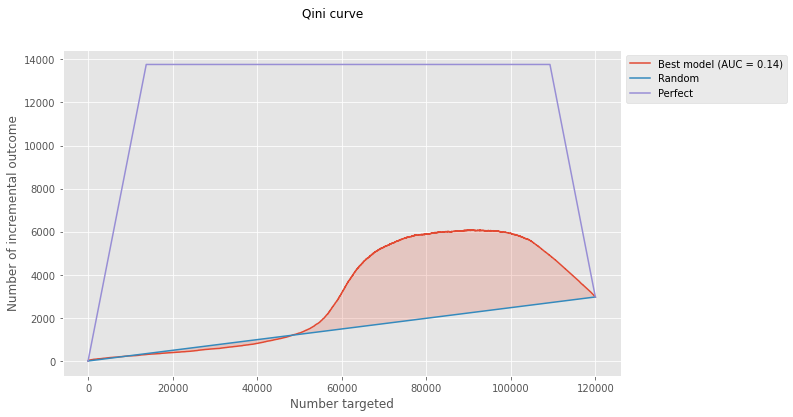

In [30]:
bets_disp = plot_qini_curve(y_test, uplift_tr, X_test['treatment_group'], perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");

In [ ]:
my_submission = pd.DataFrame({'id': idx, 'pred': uplift_tr})
my_submission.to_csv('uplift_first.csv', index=False)

## Two models

In [31]:
from sklift.models import TwoModels

In [32]:
estimator_trmnt = LGBMClassifier(silent=True, thread_count=2, random_state=42)
estimator_ctrl = XGBClassifier(silent=True, thread_count=2, random_state=42)

In [33]:
tm_ctrl = TwoModels(estimator_trmnt=estimator_trmnt,
                    estimator_ctrl=estimator_ctrl,
                    method='ddr_control')

In [34]:
tm_ctrl = tm_ctrl.fit(X_train, y_train,
                      treatment=X_train['treatment_group'])

In [35]:
uplift_tm_ctrl = tm_ctrl.predict(X_test)  # predict uplift

In [36]:
qini_auc_score(y_true=y_test, uplift=uplift_tm_ctrl,
               treatment=X_test['treatment_group'])

0.21301885933969947

In [37]:
res_two = tm_ctrl.predict(test_df)

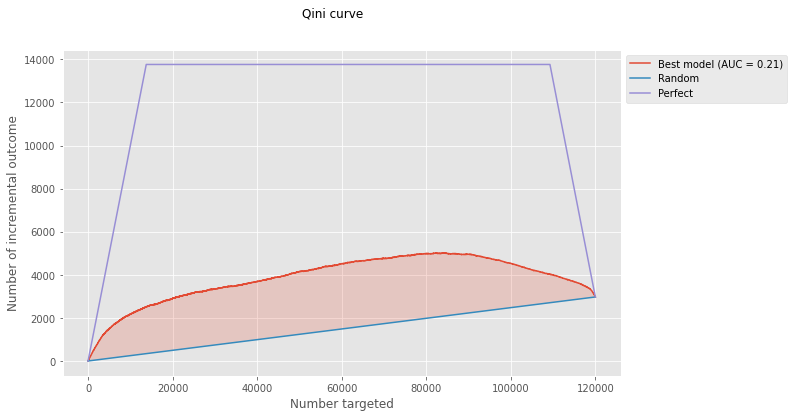

In [38]:
bets_disp = plot_qini_curve(y_test, uplift_tm_ctrl, X_test['treatment_group'], perfect=True, name='Best model');
bets_disp.figure_.suptitle("Qini curve");

In [ ]:
my_submission = pd.DataFrame({'id': idx, 'pred': res_two})
my_submission.to_csv('uplift_two.csv', index=False)